In [164]:
# Some parts of the code are borrowed from the code at the following URL.
# https://langchain-ai.github.io/langgraph/how-tos/subgraph/

from typing import Optional
from typing_extensions import TypedDict

from kenkenpa.builder import StateGraphBuilder

In [165]:
# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    answer: str
    grade: Optional[int]
    feedback: Optional[str]

# Mapping list[Logs] to register non-reserved types in StateGraphBuilder.
type_map = {
    "list_logs": list[Logs],
}



In [166]:
# Difine custom reducer 
def add_logs(left: list[Logs], right: list[Logs]) -> list[Logs]:
    if not left:
        left = []
    
    if not right:
        right = []
    
    logs = left.copy()
    left_id_to_idx = {log["id"]: idx for idx, log in enumerate(logs)}
    # update if the new logs are already in the state, otherwise append
    for log in right:
        idx = left_id_to_idx.get(log["id"])
        if idx is not None:
            logs[idx] = log
        else:
            logs.append(log)
    return logs

# Mapping reducers to be registered in StateGraphBuilder to a dictionary.
reducer_map = {
    "add_logs":add_logs,
}



In [167]:
class GetFailures():
    def __init__(self, factory_parameter,flow_parameter):
        pass
    def __call__(self, state):
        failures = [log for log in state["logs"] if log ["grade"] == 0]
        return {"failures":failures}

class FailureGenerateSummary():
    def __init__(self, factory_parameter,flow_parameter):
        pass
    def __call__(self, state):
        failures = state["failures"]
        # NOTE: you can implement custom summarization logic here
        failure_ids = [log["id"] for log in failures]
        fa_summary = f"Poor quality of retrieval for document IDs: {', '.join(failure_ids)}"
        return {"failure_report":fa_summary}

failure_analysis_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"failure_analysis",
        "state" : [
            {
                "field_name": "logs",
                "type": "list_logs",
                "reducer": "add_logs",
            },
            {
                "field_name": "failure_report",
                "type": "str",
            },
            {
                "field_name": "failures",
                "type": "list_logs",
            },
        ], 
    },
    "flows": [
        { # node get_failures
            "graph_type":"node",
            "flow_parameter": {
                "name":"GetFailures",
                "factory":"GetFailures",
            },
        },
        { # node generate_summary
            "graph_type":"node",
            "flow_parameter": {
                "name":"FailureGenerateSummary",
                "factory":"FailureGenerateSummary",
            },
        },
        { # normal_edge START -> get_failures
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"START",
                "end_key":"GetFailures"
            },
        },
        { # normal_edge get_failures -> generate_summary
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"GetFailures",
                "end_key":"FailureGenerateSummary"
            },
        },
        { # normal_edge get_failures -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"FailureGenerateSummary",
                "end_key":"END"
            },
        },
    ]
}


In [168]:
class QuestionGenerateSummary():
    def __init__(self, factory_parameter,flow_parameter):
        pass
    def __call__(self,state):
        docs = state["logs"]
        # NOTE: you can implement custom summarization logic here
        summary = "Questions focused on usage of ChatOllama and Chroma vector store"
        return {"summary":summary}

class SendToSlack():
    def __init__(self, factory_parameter,flow_parameter):
        pass
    def __call__(self,state):
        summary = state["summary"]
        # NOTE: you can implement ustom logic here, for example sending the summary generated in the previous step to Slack
        return {"summary_report":summary}

question_summarization_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"question_summarization",
        "state" : [
            {
                "field_name": "summary_report",
                "type": "str",
            },
            {
                "field_name": "logs",
                "type": "list_logs",
                "reducer": "add_logs",
            },

            {
                "field_name": "summary",
                "type": "str",
            },
        ], 
    },
    "flows": [
        { # node generate_summary
            "graph_type":"node",
            "flow_parameter": {
                "name":"QuestionGenerateSummary",
                "factory":"QuestionGenerateSummary",
            },
        },
        { # node send_to_slack
            "graph_type":"node",
            "flow_parameter": {
                "name":"SendToSlack",
                "factory":"SendToSlack",
            },
        },
        { # normal_edge START -> generate_summary
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"START",
                "end_key":"QuestionGenerateSummary"
            },
        },
        { # normal_edge generate_summary -> send_to_slack
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"QuestionGenerateSummary",
                "end_key":"SendToSlack"
            },
        },
        { # normal_edge send_to_slack -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"SendToSlack",
                "end_key":"END"
            },
        },
    ]
}


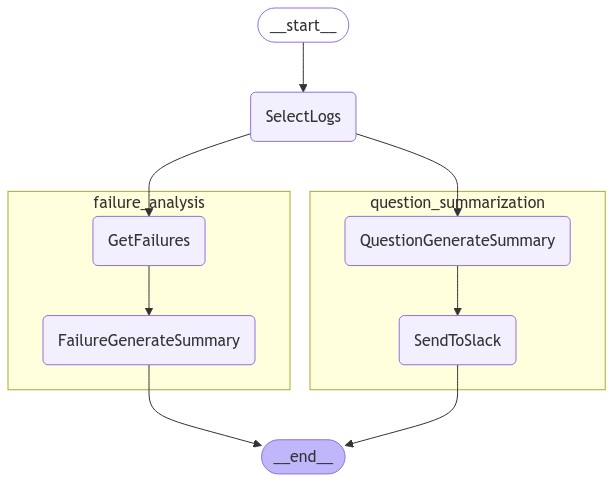

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'grade': 1,
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'},
  {'id': '3',
   'question': 'How do I create react agent in langgraph?',
   'answer': 'from langgraph.prebuilt import create_react_agent'}],
 'logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'grade': 1,
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade'

In [169]:
# Dummy logs
dummy_logs = [
    Logs(
        id="1",
        question="How can I import ChatOllama?",
        grade=1,
        answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
    ),
    Logs(
        id="2",
        question="How can I use Chroma vector store?",
        answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
        grade=0,
        feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
    ),
    Logs(
        id="3",
        question="How do I create react agent in langgraph?",
        answer="from langgraph.prebuilt import create_react_agent",
    ),
]

class SelectLogs():
    def __init__(self, factory_parameter,flow_parameter):
        pass
    def __call__(self, state):
        return {"logs": [log for log in state["raw_logs"] if "grade" in log]}

factory_map = {
    "GetFailures": GetFailures,
    "FailureGenerateSummary": FailureGenerateSummary,
    "QuestionGenerateSummary": QuestionGenerateSummary,
    "SendToSlack": SendToSlack,
    "SelectLogs": SelectLogs,
}

parent_graph_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"entry_graph",
        "state" : [
            {
                "field_name": "raw_logs",
                "type": "list_logs",
                "reducer":"add_logs"
            },
            {
                "field_name": "logs",
                "type": "list_logs",
                "reducer": "add_logs",
            },
            {
                "field_name": "failure_report",
                "type": "str",
            },
            {
                "field_name": "summary_report",
                "type": "str",
            },
        ], 
    },
    "flows": [
        { # node generate_summary
            "graph_type":"node",
            "flow_parameter": {
                "name":"SelectLogs",
                "factory":"SelectLogs",
            },
        },
        failure_analysis_settings, # subgraph failure_analysis
        question_summarization_settings, # subgraph question_summarization
        { # normal_edge START -> generate_summary
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"START",
                "end_key":"SelectLogs"
            },
        },
        { # normal_edge select_logs -> failure_analysis
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"SelectLogs",
                "end_key":"failure_analysis"
            },
        },
        { # normal_edge select_logs -> question_summarization
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"SelectLogs",
                "end_key":"question_summarization"
            },
        },
        { # normal_edge failure_analysis -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"failure_analysis",
                "end_key":"END"
            },
        },
        { # normal_edge question_summarization -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"question_summarization",
                "end_key":"END"
            },
        },
    ]
}

subgraph_builder = StateGraphBuilder(
    graph_settings=parent_graph_settings,
    node_factorys=factory_map,
    reducers=reducer_map,
    types=type_map
)
subgraph_test = subgraph_builder.gen_stategraph()

graph = subgraph_test.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

graph.invoke({"raw_logs": dummy_logs}, debug=False)
